In [8]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import torch
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay   
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.loss_functions as lf

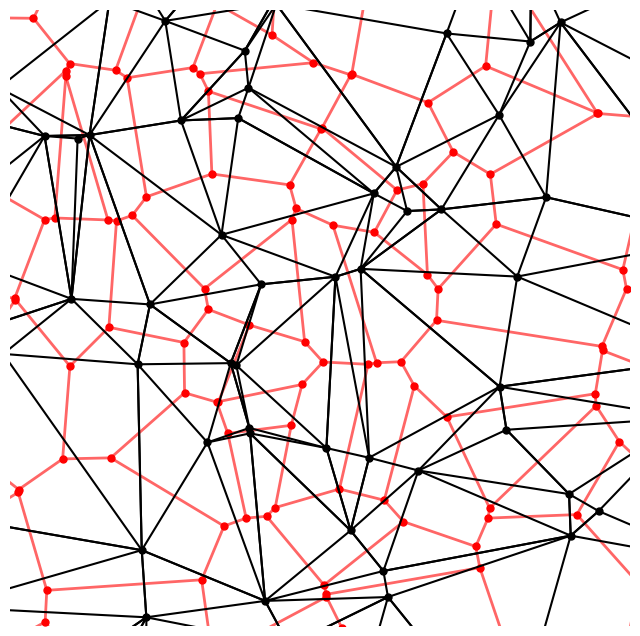

In [ ]:
N = 100

# Improve reproducibility
torch.manual_seed(69)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(69)

# Generate N site positions [0, 100] x [0, 100]
site_positions = np.random.rand(N, 2) * 100

def plot_voronoi_diagram(site_positions, output, aux_points=None, aux_points2=None):
    # Create a Voronoi diagram
    vor = Voronoi(site_positions)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='red', line_width=2, line_alpha=1.0, point_size=2)

    # Add site positions
    ax.plot(site_positions[:, 0], site_positions[:, 1], 'o', markersize=5, label='Sites', color='black')

    # Add vertices (black)
    ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'ro', markersize=5, label='Vertices')

    # Make the connection between adjacent sites
    tri = Delaunay(site_positions)
    for simplex in tri.simplices:
        ax.plot(site_positions[simplex, 0], site_positions[simplex, 1], '-', alpha=1.0, color='black')

    # DEBUG: Show the Voronoi
    # cell_centers = np.array([vor.vertices[vor.regions[i]].mean(axis=0) for i in range(len(vor.regions)) if len(vor.regions[i]) > 0])
    # ax.plot(cell_centers[:, 0], cell_centers[:, 1], 'go', markersize=5, label='Cell Centers')
    if aux_points is not None:
        ax.scatter(aux_points[:, 0], aux_points[:, 1], c='blue', s=5, label='Aux Points')
    if aux_points2 is not None:
        ax.scatter(aux_points2[:, 0], aux_points2[:, 1], c='green', s=5, label='Aux Points 2')
        
    # Crop important area
    ax.set_xlim(20, 80)
    ax.set_ylim(20, 80)

    # Remove all axes
    ax.axis('off')

    # Save as svg
    plt.savefig(output, format='svg', bbox_inches='tight')
    plt.show()

plot_voronoi_diagram(site_positions, 'voronoi_diagram.svg')

Computing CVT loss...
tensor(-232.3660) tensor(396.5879)
tensor(-14.5899) tensor(125.4097)


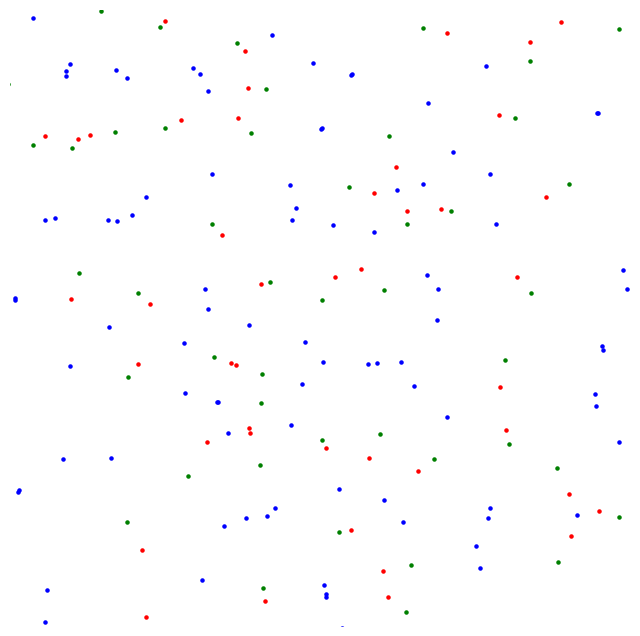

In [11]:
# Compute CVT loss
def compute_cvt_loss(sites, d3d):
    vertices = su.compute_vertices_2d_vectorized(sites, d3d)
    
    # Concat sites and vertices to compute the Voronoi diagram
    points = torch.concatenate((sites, vertices), axis=0)
    d3dsimplices = Delaunay(points.detach().cpu().numpy()).simplices
    d3dsimplices = torch.tensor(d3dsimplices, dtype=torch.int64, device=sites.device)
    
    # Compute the areas of all simplices (in 2D triangles)
    a = points[d3dsimplices[:, 0]]
    b = points[d3dsimplices[:, 1]]
    c = points[d3dsimplices[:, 2]]
    # areas_simplices = torch.linalg.norm(torch.cross(b - a, c - a), dim=1) / 2.0
    triangle_areas = torch.linalg.norm(b - a, dim=1) * torch.linalg.norm(c - a, dim=1) / 2.0
    triangle_center = (a + b + c) / 3.0
    # print(triangle_areas.shape, triangle_center.shape)

    # Create a centroid for each sites
    centroids = torch.zeros_like(sites)
    areas = torch.zeros(sites.shape[0], dtype=torch.float32, device=sites.device)
    for i in range(3):
        # Filter simplices that are valid (i.e., not out of bounds)
        # We assume that the first N points are the sites
        mask = d3dsimplices[:, i] < sites.shape[0]
        # Uses index_add for atomic addition
        centroids.index_add_(0, d3dsimplices[mask, i], triangle_center[mask] * triangle_areas[mask].unsqueeze(1))
        areas.index_add_(0, d3dsimplices[mask, i], triangle_areas[mask])
    centroids /= areas.unsqueeze(1)
    
    # print("Centroids shape:", centroids.shape)
    # print("Sites shape:", sites.shape)
    return centroids, vertices
    

# Compute CVT loss
site_positions_torch = torch.tensor(site_positions, dtype=torch.float32)
d3dsimplices = Delaunay(site_positions_torch.detach().cpu().numpy()).simplices

print("Computing CVT loss...")
centroid, vertices = compute_cvt_loss(site_positions_torch, d3dsimplices)
print(torch.min(vertices), torch.max(vertices))
print(torch.min(centroid), torch.max(centroid))

centroids_avg = lf.compute_voronoi_cell_centers_index_based_torch(site_positions_torch, None, d3dsimplices)

# plot_voronoi_diagram(site_positions, 'voronoi_diagram_with_cvt.svg', aux_points=centroid.detach().cpu().numpy(), aux_points2=centroids_avg.detach().cpu().numpy())

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(site_positions[:, 0], site_positions[:, 1], c='red', s=5, label='Sites')
plt.scatter(vertices.detach().cpu().numpy()[:, 0], vertices.detach().cpu().numpy()[:, 1], c='blue', s=5, label='Vertices')
plt.scatter(centroid.detach().cpu().numpy()[:, 0], centroid.detach().cpu().numpy()[:, 1], c='green', s=5, label='Centroids')
plt.xlim(20, 80)
plt.ylim(20, 80)
plt.axis('off')
plt.savefig('cvt_centroids.svg', format='svg', bbox_inches='tight')
plt.show()

# Ray traced CVT

In [ ]:
# cvt_loss, x, xp = lf.compute_cvt_dist(torch.tensor(site_positions, dtype=torch.float32, device=0), M=100, N=40, random=False, max_distance=1000)
# print(f'CVT Loss: {cvt_loss.item()}')
# print(x.shape)
# print(f'CVT X: {x}')
# plot_voronoi_diagram(site_positions, 'voronoi_diagram_with_aux.svg', aux_points=x.detach().cpu().numpy())

# # Plot all points in x
# plt.figure(figsize=(8, 8))
# plt.scatter(site_positions[:, 0], site_positions[:, 1], c='red', label='Sites')
# plt.scatter(x[:, 0].detach().cpu().numpy(), x[:, 1].detach().cpu().numpy(), c='blue', label='Aux Points')
# plt.scatter(xp[:, 0].detach().cpu().numpy(), xp[:, 1].detach().cpu().numpy(), c='green', label='Aux Points Opposite')
# plt.xlim(0, 100)
# plt.ylim(0, 100)
# plt.legend()
# plt.title('Sites and Auxiliary Points')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.grid(True)
# plt.savefig('sites_and_aux_points.svg', format='svg', bbox_inches='tight')
# plt.show()


Energy: 3.813066005706787
Energy: 3.688666343688965
Energy: 3.557239532470703
Energy: 3.491152286529541
Energy: 3.4042201042175293
Energy: 3.321864604949951
Energy: 3.2513506412506104
Energy: 3.212907552719116
Energy: 3.1705031394958496
Energy: 3.1059651374816895
Energy: 3.032938241958618
Energy: 2.9887094497680664
Energy: 2.971916437149048
Energy: 2.946436643600464
Energy: 2.903853416442871
Energy: 2.85726261138916
Energy: 3.1530449390411377
Energy: 3.1379754543304443
Energy: 3.1023998260498047
Energy: 3.0734148025512695
Energy: 3.139421224594116
Energy: 3.108640670776367
Energy: 3.0750789642333984
Energy: 3.059417724609375
Energy: 3.033047914505005
Energy: 3.0165836811065674
Energy: 2.995272159576416
Energy: 3.0009593963623047
Energy: 2.9667561054229736
Energy: 2.917689085006714
Energy: 2.880720376968384
Energy: 2.8546178340911865
Energy: 2.8564958572387695
Energy: 2.8438451290130615
Energy: 2.827807664871216
Energy: 2.7928547859191895
Energy: 2.76922607421875
Energy: 2.7642498016357

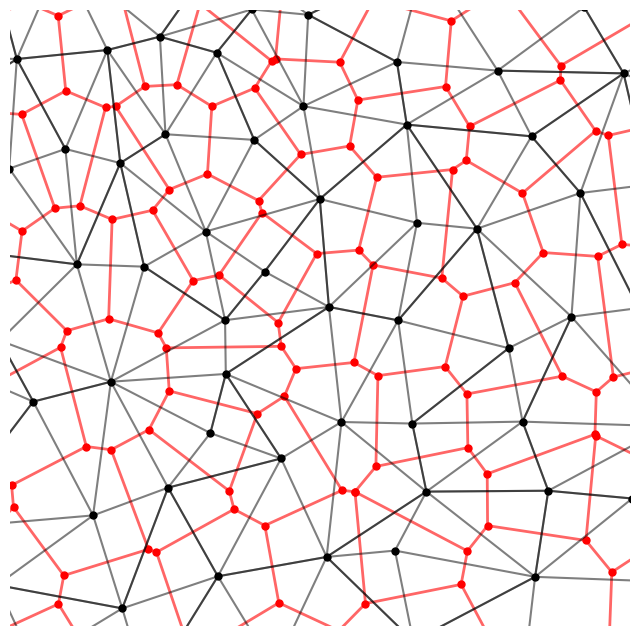

In [13]:
# Optimize the site position with pytorch to minimize the CVT energy
site_positions_tensor = torch.tensor(site_positions, dtype=torch.float32, requires_grad=True, device=0)
optimizer = torch.optim.Adam([site_positions_tensor], lr=0.01)

torch.autograd.set_detect_anomaly(True)

for _ in range(1000):
    optimizer.zero_grad()
    d3dsimplices = Delaunay(site_positions_tensor.detach().cpu().numpy()).simplices
    
    #cvt_loss = lf.compute_cvt_loss_vectorized_delaunay(site_positions_tensor, None, d3dsimplices, max_distance=1000)
    
    # SIMPLIFIED computation of CVT loss with rays
    # cvt_loss, _, _ = lf.compute_cvt_dist(site_positions_tensor, N=40, max_distance=40)
    
    # TRUE computation of CVT loss
    centroid, _ = compute_cvt_loss(site_positions_tensor, d3dsimplices)
    cvt_loss = torch.mean(torch.norm(site_positions_tensor - centroid, dim=1))

    energy = cvt_loss.mean()
    energy.backward()
    print(f'Energy: {energy.item()}')
    optimizer.step()

# Plot the optimized Voronoi diagram
optimized_site_positions = site_positions_tensor.detach().cpu().numpy()
plot_voronoi_diagram(optimized_site_positions, 'optimized_voronoi_diagram.svg')